In [88]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

In [89]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler


In [90]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

DATA PREPROCESSING

In [91]:
# Define the ticker symbol and the date range
ticker = 'JNJ'
start_date = '2019-12-01'
end_date = '2025-06-30' # Adjust end date as needed

# Fetch the data
df_download = yf.download(ticker, start=start_date, end=end_date)

/var/folders/63/lpwssx6x59gb12p2395wtvfw0000gn/T/ipykernel_3464/4258457617.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_download = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


In [92]:
df_download.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
df = df_download.reset_index()
df['Date'] = pd.to_datetime(df['Date'])
df

,Date,Close,High,Low,Open,Volume
0,2019-12-02,116.017952,116.431824,115.587197,116.322018,4717100
1,2019-12-03,115.849030,116.093966,115.004403,115.637873,5741400
2,2019-12-04,117.724083,118.028149,116.592273,116.980807,7257300
3,2019-12-05,117.876122,118.036603,116.516272,117.698757,5472900
4,2019-12-06,118.568718,119.582268,117.791663,117.791663,6640400
...,...,...,...,...,...,...
1395,2025-06-23,149.269653,149.378148,147.711060,147.711060,7397900
1396,2025-06-24,150.127869,150.650686,148.934257,149.447216,9544200
1397,2025-06-25,150.216644,150.995948,148.687643,149.328845,7153700
1398,2025-06-26,149.950287,151.143898,149.476795,150.630940,7156900


In [93]:
df['Close_Yesterday'] = df['Close'].shift(1)
df['High_Yesterday'] = df['High'].shift(1)
df['Low_Yesterday'] = df['Low'].shift(1)
df['Open_Yesterday'] = df['Open'].shift(1)
df['Volume_Yesterday'] = df['Volume'].shift(1)
df['High_Low_Range'] = df['High'] - df['Low']
df['MA5_Weekly'] = df['Close'].rolling(window=5, min_periods=1).mean()
df['MA21_Monthly'] = df['Close'].rolling(window=21, min_periods=1).mean()
df['Vol_W_MA5'] = df['Volume'].rolling(window=5, min_periods=1).mean()
df['Vol_M_MA21'] = df['Volume'].rolling(window=21, min_periods=1).mean()
df['C_EMA5_Weekly'] = df['Close'].ewm(span=5, adjust=False).mean()
df['C_EMA21_Monthly'] = df['Close'].ewm(span=21, adjust=False).mean()
df['Vol_W_EMA5'] = df['Volume'].ewm(span=5, adjust=False).mean()
df['Vol_M_EMA21'] = df['Volume'].ewm(span=21, adjust=False).mean()

ranged_df = df[(df['Date'] >= '2020-01-01') & (df['Date'] <= '2024-12-31')]
cleaned_df = ranged_df.drop(columns=['High','Low', 'Open', 'Volume'])
cleaned_df

,Date,Close,Close_Yesterday,High_Yesterday,Low_Yesterday,Open_Yesterday,Volume_Yesterday,High_Low_Range,MA5_Weekly,MA21_Monthly,Vol_W_MA5,Vol_M_MA21,C_EMA5_Weekly,C_EMA21_Monthly,Vol_W_EMA5,Vol_M_EMA21
21,2020-01-02,123.290207,123.205711,123.323959,122.285071,122.555358,4435000.0,0.793951,123.099294,120.729756,3917460.0,6.134357e+06,123.086996,121.089151,4.856163e+06,5.680694e+06
22,2020-01-03,121.862755,123.290207,123.332441,122.538489,123.205739,5777000.0,2.001761,122.837463,121.016124,4464080.0,6.134881e+06,122.678916,121.159478,5.154909e+06,5.687213e+06
23,2020-01-06,121.710716,121.862755,122.783395,120.781634,121.203947,5752400.0,1.140238,122.558731,121.205963,5323800.0,6.157452e+06,122.356182,121.209591,6.013706e+06,5.873039e+06
24,2020-01-07,122.454002,121.710716,121.795171,120.654933,121.626248,7731300.0,3.437625,122.504678,121.423958,6215720.0,6.248405e+06,122.388789,121.322719,6.470104e+06,6.010299e+06
25,2020-01-08,122.437126,122.454002,122.850978,119.413353,121.634713,7382900.0,1.925748,122.350961,121.608168,6649880.0,6.246757e+06,122.404901,121.424029,6.515336e+06,6.064436e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1274,2024-12-24,141.518036,140.955261,141.013477,139.189311,140.334271,8720800.0,1.474858,140.483694,144.548597,9688100.0,8.727733e+06,140.970683,143.767485,8.389285e+06,8.862587e+06
1275,2024-12-26,141.256042,141.518036,141.518036,140.043178,140.693276,3164100.0,1.241981,140.644763,144.134603,8752140.0,8.365833e+06,141.065803,143.539172,7.144956e+06,8.480197e+06
1276,2024-12-27,140.741791,141.256042,142.022572,140.780591,141.188114,4656300.0,1.862986,140.930029,143.697045,7966460.0,8.361300e+06,140.957799,143.284864,6.626071e+06,8.217297e+06
1277,2024-12-30,139.082565,140.741791,142.245756,140.382770,140.567129,5588300.0,1.872684,140.710739,143.139816,5679640.0,8.462648e+06,140.332721,142.902837,6.506947e+06,8.040152e+06


Dependend and Independent Variables

In [94]:
features = list(cleaned_df.columns[2:])
features #Independent Variables

['Close_Yesterday',
 'High_Yesterday',
 'Low_Yesterday',
 'Open_Yesterday',
 'Volume_Yesterday',
 'High_Low_Range',
 'MA5_Weekly',
 'MA21_Monthly',
 'Vol_W_MA5',
 'Vol_M_MA21',
 'C_EMA5_Weekly',
 'C_EMA21_Monthly',
 'Vol_W_EMA5',
 'Vol_M_EMA21']

In [95]:
x = cleaned_df[features]
y = cleaned_df['Close']

In [96]:
# split the data into train and test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = 23)

## 1. Random Forest

In [97]:
rf = RandomForestRegressor()
params_rf = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_gs = RandomizedSearchCV(rf, params_rf, scoring='neg_mean_squared_error', cv=5, n_iter=50)
rf_gs.fit(x_train, y_train.values.ravel())

,estimator,RandomForestRegressor()
,param_distributions,"{'max_depth': [None, 10, ...], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...], 'n_estimators': [50, 100, ...]}"
,n_iter,50
,scoring,'neg_mean_squared_error'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [98]:
#save best model
rf_best = rf_gs.best_estimator_
#check best parameters value
print(rf_gs.best_params_)

{'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None}


In [99]:
rf_best = RandomForestRegressor(n_estimators = rf_gs.best_params_['n_estimators'], max_depth=rf_gs.best_params_['max_depth'], min_samples_leaf=rf_gs.best_params_['min_samples_leaf'], min_samples_split=rf_gs.best_params_['min_samples_split'])
rf_best_model = rf_best.fit(x_train,y_train.values.ravel())
rf_pred = rf_best_model.predict (x_test)

In [100]:
mse_rf = mean_squared_error(y_test, rf_pred)
mae_rf = mean_absolute_error(y_test, rf_pred)
mape_rf = mean_absolute_percentage_error(y_test, rf_pred)

print("MSE:", mse_rf)
print("MAE:", mae_rf)
print("MAPE:", mape_rf)

MSE: 1.9071287510329644
MAE: 0.9656578965681514
MAPE: 0.006826742408298678


In [101]:
importances = rf_best_model.feature_importances_
feature_names = x_train.columns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})
feature_importance_df.sort_values('Importance', ascending=False)

,Feature,Importance
0,Close_Yesterday,0.599949
10,C_EMA5_Weekly,0.236007
6,MA5_Weekly,0.027416
3,Open_Yesterday,0.027209
2,Low_Yesterday,0.022903
12,Vol_W_EMA5,0.022651
1,High_Yesterday,0.020530
11,C_EMA21_Monthly,0.019136
7,MA21_Monthly,0.017466
8,Vol_W_MA5,0.003668


## 2. GradientBoostRegressor Model

In [102]:
gb = GradientBoostingRegressor()
params_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}
gb_gs = RandomizedSearchCV(gb, params_gb, scoring='neg_mean_squared_error', cv=5, n_iter=50)
gb_gs.fit(x_train, y_train.values.ravel())

,estimator,GradientBoostingRegressor()
,param_distributions,"{'learning_rate': [0.01, 0.05, ...], 'max_depth': [3, 5, ...], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...], ...}"
,n_iter,50
,scoring,'neg_mean_squared_error'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [103]:
#save best model
gb_best = gb_gs.best_estimator_
#check best n_estimators value
print(gb_gs.best_params_)

{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 5, 'learning_rate': 0.1}


In [104]:
gb_best = GradientBoostingRegressor(n_estimators = gb_gs.best_params_['n_estimators'], learning_rate=gb_gs.best_params_['learning_rate'], max_depth=gb_gs.best_params_['max_depth'], min_samples_leaf=gb_gs.best_params_['min_samples_leaf'], min_samples_split=gb_gs.best_params_['min_samples_split'])
gb_best_model = gb_best.fit(x_train,y_train.values.ravel())
gb_pred = gb_best_model.predict (x_test)

In [105]:
mse_gb = mean_squared_error(y_test, gb_pred)
mae_gb = mean_absolute_error(y_test, gb_pred)
mape_gb = mean_absolute_percentage_error(y_test, gb_pred)

print("MSE:", mse_gb)
print("MAE:", mae_gb)
print("MAPE:", mape_gb)

MSE: 1.8262875811740418
MAE: 0.948906854160209
MAPE: 0.006684169352035466


## 3. Neural Network

Standardization

In [130]:
x_scaler = StandardScaler()
x_train_scaled = x_scaler.fit_transform(x_train)
x_test_scaled = x_scaler.transform(x_test)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1))

In [131]:
print(f"x_train shape: {x_train_scaled.shape}")
print(f"x_train_scaled shape: {x_train_scaled.shape}")

x_train shape: (1006, 14)
x_train_scaled shape: (1006, 14)


In [132]:
input_shape=(14,)

model_NN = keras.Sequential([
    # 1st Layer
    tf.keras.layers.Dense(128, input_shape=input_shape, kernel_regularizer=regularizers.l2(0.005)),
    tf.keras.layers.Activation('relu'),

    # 2nd Layer
    tf.keras.layers.Dense(64, input_shape=input_shape, kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Activation('relu'),

    # Output
    tf.keras.layers.Dense(1)
])

optimizer = keras.optimizers.Adam(
    learning_rate=0.0001,
    clipnorm=1.0
)

model_NN.compile(
    optimizer=optimizer,
    loss='mean_squared_error',
    metrics=['mae', 'mse']  # Track MAE and MSE
    )

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [133]:
model_output = model_NN.fit(x_train_scaled, y_train_scaled, epochs=100, verbose=1, validation_data=(x_test_scaled, y_test_scaled))

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.8965 - mae: 0.6223 - mse: 0.6820 - val_loss: 0.5419 - val_mae: 0.4264 - val_mse: 0.3277
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4701 - mae: 0.3520 - mse: 0.2562 - val_loss: 0.2946 - val_mae: 0.1957 - val_mse: 0.0812
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2853 - mae: 0.1792 - mse: 0.0725 - val_loss: 0.2433 - val_mae: 0.1371 - val_mse: 0.0313
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2529 - mae: 0.1454 - mse: 0.0418 - val_loss: 0.2356 - val_mae: 0.1228 - val_mse: 0.0255
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2416 - mae: 0.1313 - mse: 0.0325 - val_loss: 0.2309 - val_mae: 0.1129 - val_mse: 0.0228
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2354 - mae: 0.1235 - mse: 0.0282 - val_loss: 0.2276 - val_mae: 0.1081 - val_mse: 0.0214
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2305 - mae: 0.1179 - mse: 0.0252 - val_loss: 

In [135]:
y_pred_scaled = model_NN.predict(x_test_scaled)

NN_pred = y_scaler.inverse_transform(y_pred_scaled)
NN_test = y_scaler.inverse_transform(y_test_scaled)


mse_NN = mean_squared_error(NN_test, NN_pred)
mae_NN = mean_absolute_error(y_test, NN_pred)
mape_NN = mean_absolute_percentage_error(y_test, NN_pred)

print("MSE:", mse_NN)
print("MAE:", mae_NN)
print("MAPE:", mape_NN)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MSE: 1.6458492881587488
MAE: 0.9123195163787358
MAPE: 0.006419310837990725


## Try the model to 1st Half of 2025

In [110]:
final_test_df = df[(df['Date'] >= '2025-01-01') & (df['Date'] <= '2025-06-30')]
cleaned_finaltest=final_test_df.drop(columns=['High','Low', 'Open', 'Volume'])
cleaned_finaltest

,Date,Close,Close_Yesterday,High_Yesterday,Low_Yesterday,Open_Yesterday,Volume_Yesterday,High_Low_Range,MA5_Weekly,MA21_Monthly,Vol_W_MA5,Vol_M_MA21,C_EMA5_Weekly,C_EMA21_Monthly,Vol_W_EMA5,Vol_M_EMA21
1279,2025-01-02,139.742386,140.324570,140.373088,139.053481,139.490112,5811400.0,1.930899,140.229471,142.161663,5675200.0,8.425905e+06,140.134131,142.402443,6.200499e+06,7.675153e+06
1280,2025-01-03,139.907333,139.742386,141.440408,139.509509,140.916439,6051300.0,0.921795,139.959729,141.784170,5919700.0,8.292781e+06,140.058532,142.175615,6.093266e+06,7.511848e+06
1281,2025-01-06,139.393066,139.907333,140.276052,139.354256,139.790902,5878800.0,1.833878,139.689984,141.469516,6384140.0,8.177419e+06,139.836710,141.922656,6.699011e+06,7.548089e+06
1282,2025-01-07,141.886749,139.393066,140.518616,138.684738,139.247513,7910500.0,3.483368,140.250821,141.317502,6814800.0,8.202367e+06,140.520056,141.919392,7.273340e+06,7.627536e+06
1283,2025-01-08,138.044357,141.886749,142.808530,139.325162,139.490111,8422000.0,4.026732,139.794778,140.992221,7887640.0,8.335033e+06,139.694823,141.567116,8.574094e+06,7.950087e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,2025-06-23,149.269653,147.760376,149.348561,147.020538,149.210459,22605500.0,1.667088,149.829953,151.692219,10351940.0,8.007243e+06,149.833694,151.266712,1.068045e+07,8.593375e+06
1396,2025-06-24,150.127869,149.269653,149.378148,147.711060,147.711060,7397900.0,1.716429,149.232166,151.733424,10855980.0,8.102905e+06,149.931752,151.163181,1.030170e+07,8.679814e+06
1397,2025-06-25,150.216644,150.127869,150.650686,148.934257,149.447216,9544200.0,2.308305,149.212436,151.763487,11005300.0,8.123210e+06,150.026716,151.077132,9.252368e+06,8.541076e+06
1398,2025-06-26,149.950287,150.216644,150.995948,148.687643,149.328845,7153700.0,1.667103,149.464966,151.705239,10771640.0,8.131124e+06,150.001240,150.974692,8.553879e+06,8.415242e+06


In [111]:
final_features = list(cleaned_finaltest.columns[2:])

x_final = cleaned_finaltest[final_features]
y_final = cleaned_finaltest['Close']

### Random Forest

In [112]:
rf_finalpred = rf_best_model.predict(x_final)

mse_rf_finalpred = mean_squared_error(y_final, rf_finalpred)
mae_rf_finalpred = mean_absolute_error(y_final, rf_finalpred)
mape_rf_finalpred = mean_absolute_percentage_error(y_final, rf_finalpred)

print("Final Prediction MSE:", mse_rf_finalpred)
print("Final Prediction MAE:", mae_rf_finalpred)
print("Final Prediction MAPE:", mape_rf_finalpred)

Final Prediction MSE: 2.2068306576389745
Final Prediction MAE: 1.0278467818091692
Final Prediction MAPE: 0.006792884363448179


In [113]:
start_idx = y_final.index[0]
end_idx = y_final.index[-1]

dates = df['Date'].iloc[start_idx:end_idx+1]

rf_finalpred_df = pd.DataFrame({
    'Date': dates.values,
    'Predicted': rf_finalpred,
    'Actual': y_final
})

rf_finalpred_df

,Date,Predicted,Actual
1279,2025-01-02,140.107967,139.742386
1280,2025-01-03,139.836040,139.907333
1281,2025-01-06,140.039904,139.393066
1282,2025-01-07,140.765532,141.886749
1283,2025-01-08,138.554933,138.044357
...,...,...,...
1395,2025-06-23,148.888302,149.269653
1396,2025-06-24,149.399826,150.127869
1397,2025-06-25,149.909316,150.216644
1398,2025-06-26,149.747022,149.950287


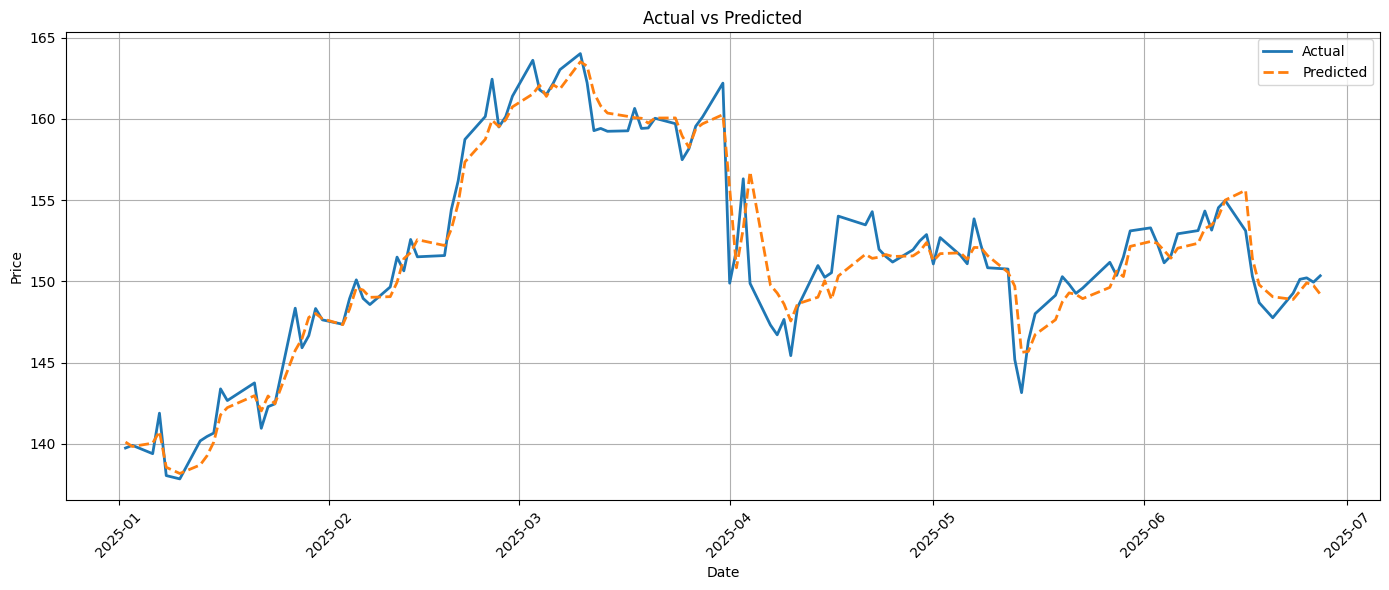

In [114]:
plt.figure(figsize=(14, 6))
plt.plot(rf_finalpred_df['Date'], rf_finalpred_df['Actual'], label='Actual', linewidth=2)
plt.plot(rf_finalpred_df['Date'], rf_finalpred_df['Predicted'], label='Predicted', linewidth=2, linestyle='--')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## GradientBoost Model

In [115]:
gb_finalpred = gb_best_model.predict (x_final)

mse_gb_finalpred = mean_squared_error(y_final, gb_finalpred)
mae_gb_finalpred = mean_absolute_error(y_final, gb_finalpred)
mape_gb_finalpred = mean_absolute_percentage_error(y_final, gb_finalpred)

print("Final Prediction MSE:", mse_gb_finalpred)
print("Final Prediction MAE:", mae_gb_finalpred)
print("Final Prediction MAPE:", mape_gb_finalpred)

Final Prediction MSE: 1.932537664446952
Final Prediction MAE: 0.9779507949041599
Final Prediction MAPE: 0.006455477204425477


In [116]:
start_idx = y_final.index[0]
end_idx = y_final.index[-1]

dates = df['Date'].iloc[start_idx:end_idx+1]

gb_finalpred_df = pd.DataFrame({
    'Date': dates.values,
    'Predicted': gb_finalpred,
    'Actual': y_final
})

gb_finalpred_df

,Date,Predicted,Actual
1279,2025-01-02,139.869794,139.742386
1280,2025-01-03,139.818019,139.907333
1281,2025-01-06,139.854321,139.393066
1282,2025-01-07,140.369508,141.886749
1283,2025-01-08,138.321034,138.044357
...,...,...,...
1395,2025-06-23,149.342485,149.269653
1396,2025-06-24,150.201958,150.127869
1397,2025-06-25,150.082290,150.216644
1398,2025-06-26,149.815757,149.950287


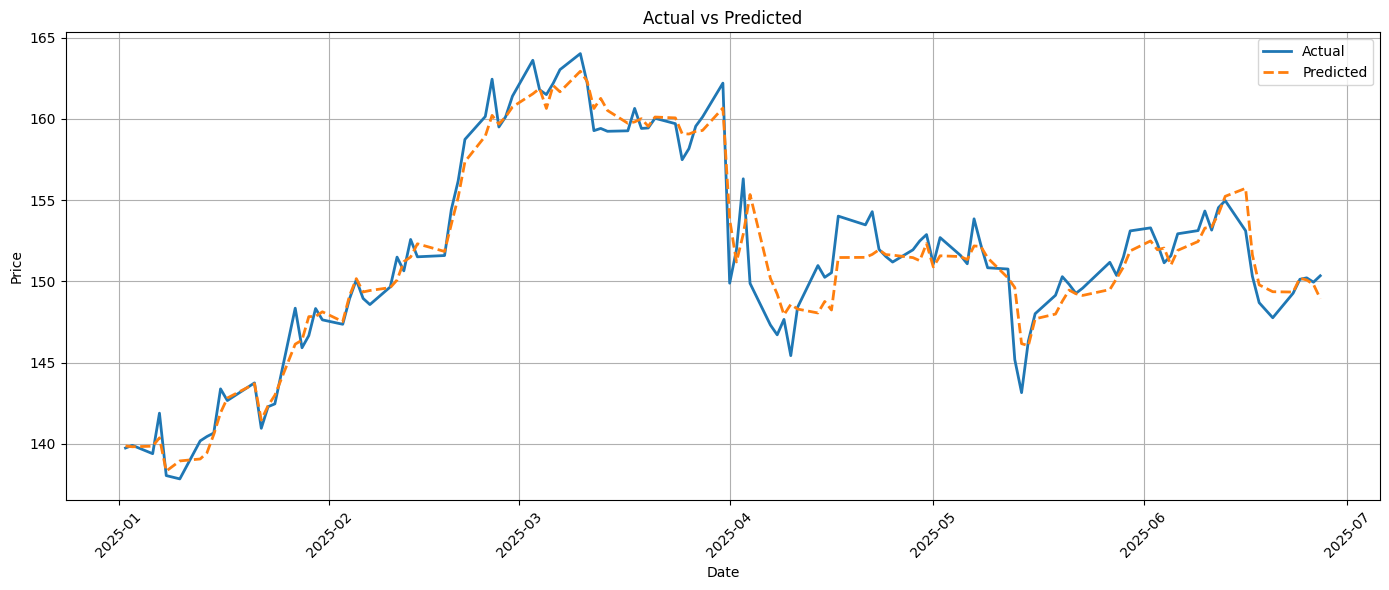

In [117]:
plt.figure(figsize=(14, 6))
plt.plot(gb_finalpred_df['Date'], gb_finalpred_df['Actual'], label='Actual', linewidth=2)
plt.plot(gb_finalpred_df['Date'], gb_finalpred_df['Predicted'], label='Predicted', linewidth=2, linestyle='--')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Neural Network Model

Data Preprocessing

In [118]:
x_final_scaled = x_scaler.transform(x_final)
y_final_scaled = y_scaler.transform(y_final.values.reshape(-1, 1))


In [119]:
NN_finalpred = model_NN.predict(x_final_scaled)

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x16254c5e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [120]:
NN_finalpred_real = y_scaler.inverse_transform(NN_finalpred)

In [121]:
start_idx = y_final.index[0]
end_idx = y_final.index[-1]

dates = df['Date'].iloc[start_idx:end_idx+1]

NN_finalpred_df = pd.DataFrame({
    'Date': dates.values,
    'Predicted': NN_finalpred_real.flatten(),
    'Actual': y_final
})

NN_finalpred_df

,Date,Predicted,Actual
1279,2025-01-02,140.064865,139.742386
1280,2025-01-03,140.310226,139.907333
1281,2025-01-06,139.869125,139.393066
1282,2025-01-07,140.733505,141.886749
1283,2025-01-08,140.614197,138.044357
...,...,...,...
1395,2025-06-23,148.864197,149.269653
1396,2025-06-24,149.677765,150.127869
1397,2025-06-25,150.007233,150.216644
1398,2025-06-26,149.908646,149.950287


In [122]:
predictions = NN_finalpred_df['Predicted'].values
actuals = NN_finalpred_df['Actual'].values

mse_NN_finalpred = mean_squared_error(actuals, predictions)
mae_NN_finalpred = mean_absolute_error(actuals, predictions)
mape_NN_finalpred = mean_absolute_percentage_error(actuals, predictions)


print("Final Prediction MSE:", mse_NN_finalpred)
print("Final Prediction MAE:", mae_NN_finalpred)
print("Final Prediction MAPE:", mape_NN_finalpred)

Final Prediction MSE: 2.8157076807076895
Final Prediction MAE: 1.1765411629164515
Final Prediction MAPE: 0.007794427708312331


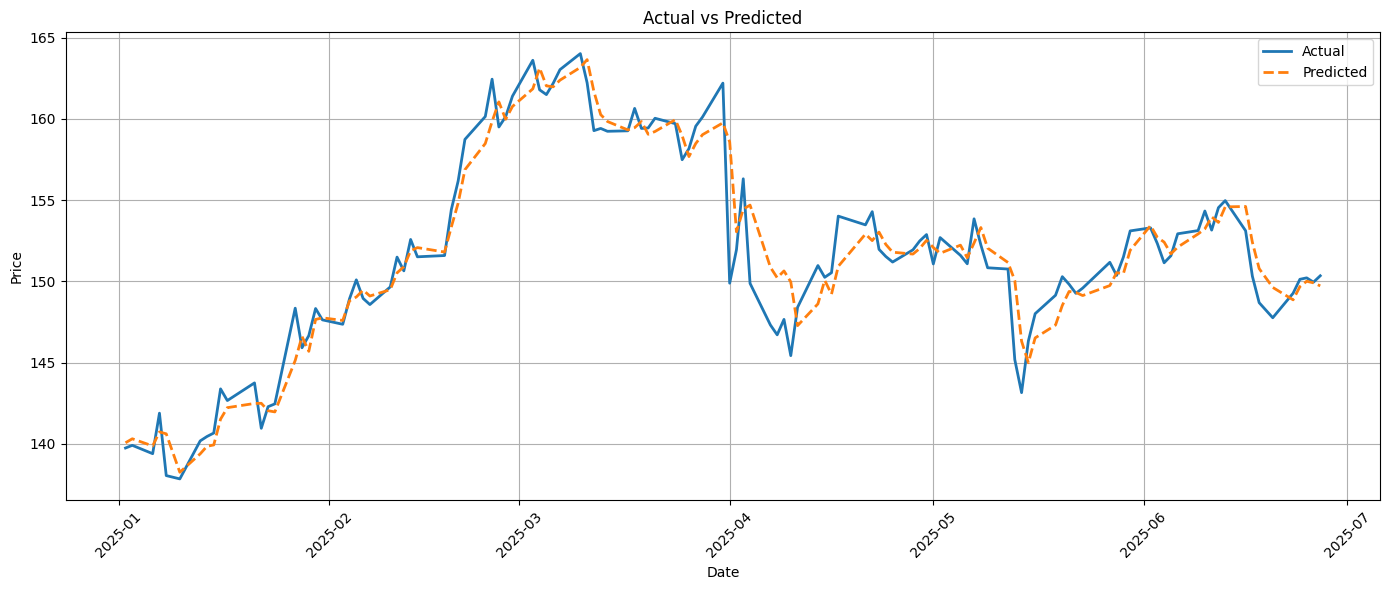

In [123]:
plt.figure(figsize=(14, 6))
plt.plot(NN_finalpred_df['Date'], NN_finalpred_df['Actual'], label='Actual', linewidth=2)
plt.plot(NN_finalpred_df['Date'], NN_finalpred_df['Predicted'], label='Predicted', linewidth=2, linestyle='--')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## SUMMARY

In [124]:
summary_df = pd.DataFrame({
    'Date': dates.values,
    'Actual': y_final,
    'Random Forest Prediction': rf_finalpred,
    'Gradient Boost Prediction': gb_finalpred,
    'Neural Network Prediction': NN_finalpred_real.flatten()
})

summary_df

,Date,Actual,Random Forest Prediction,Gradient Boost Prediction,Neural Network Prediction
1279,2025-01-02,139.742386,140.107967,139.869794,140.064865
1280,2025-01-03,139.907333,139.836040,139.818019,140.310226
1281,2025-01-06,139.393066,140.039904,139.854321,139.869125
1282,2025-01-07,141.886749,140.765532,140.369508,140.733505
1283,2025-01-08,138.044357,138.554933,138.321034,140.614197
...,...,...,...,...,...
1395,2025-06-23,149.269653,148.888302,149.342485,148.864197
1396,2025-06-24,150.127869,149.399826,150.201958,149.677765
1397,2025-06-25,150.216644,149.909316,150.082290,150.007233
1398,2025-06-26,149.950287,149.747022,149.815757,149.908646


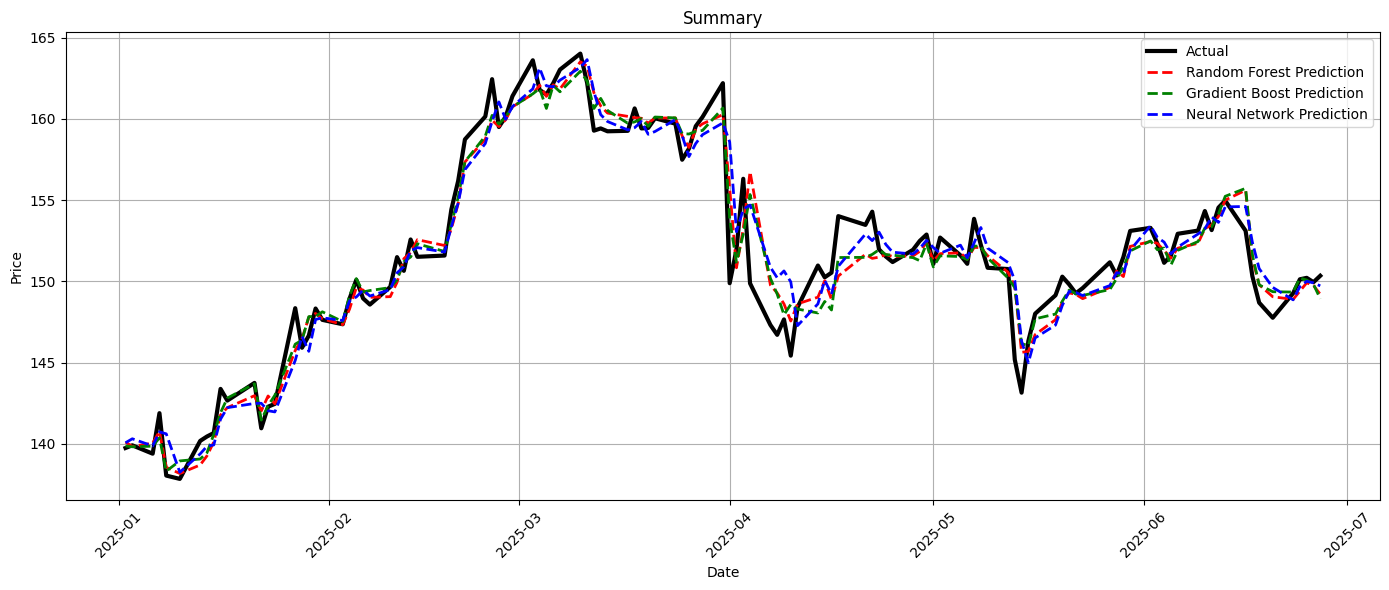

In [125]:
plt.figure(figsize=(14, 6))
plt.plot(summary_df['Date'], summary_df['Actual'], label='Actual', linewidth=3, color="black")
plt.plot(summary_df['Date'], summary_df['Random Forest Prediction'], label='Random Forest Prediction', linewidth=2, linestyle='--', color='red')
plt.plot(summary_df['Date'], summary_df['Gradient Boost Prediction'], label='Gradient Boost Prediction', linewidth=2, linestyle='--', color='green')
plt.plot(summary_df['Date'], summary_df['Neural Network Prediction'], label='Neural Network Prediction', linewidth=2, linestyle='--', color='blue')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Summary')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Further Improvement -- Model Ensemble

In [126]:
summary_df

,Date,Actual,Random Forest Prediction,Gradient Boost Prediction,Neural Network Prediction
1279,2025-01-02,139.742386,140.107967,139.869794,140.064865
1280,2025-01-03,139.907333,139.836040,139.818019,140.310226
1281,2025-01-06,139.393066,140.039904,139.854321,139.869125
1282,2025-01-07,141.886749,140.765532,140.369508,140.733505
1283,2025-01-08,138.044357,138.554933,138.321034,140.614197
...,...,...,...,...,...
1395,2025-06-23,149.269653,148.888302,149.342485,148.864197
1396,2025-06-24,150.127869,149.399826,150.201958,149.677765
1397,2025-06-25,150.216644,149.909316,150.082290,150.007233
1398,2025-06-26,149.950287,149.747022,149.815757,149.908646


In [127]:
rmse_rf = np.sqrt(mse_rf_finalpred)
rmse_gb = np.sqrt(mse_gb_finalpred)
rmse_nn = np.sqrt(mse_NN_finalpred)

total = (1/rmse_rf) + (1/rmse_gb) + (1/rmse_nn)
weights_rmse = [
    (1/rmse_rf)/total,
    (1/rmse_gb)/total,
    (1/rmse_nn)/total
]

summary_df['Ensemble Method Prediction'] = (
    weights_rmse[0] * summary_df['Random Forest Prediction'] +
    weights_rmse[1] * summary_df['Gradient Boost Prediction'] +
    weights_rmse[2] * summary_df['Neural Network Prediction']
)

# total_performance = (1/mse_rf_finalpred) + (1/mape_gb_finalpred) + (1/mape_NN_finalpred)
# weights_smart = [
#     (1/mape_rf_finalpred) / total_performance,
#     (1/mape_gb_finalpred) / total_performance,
#     (1/mape_NN_finalpred) / total_performance
# ]

# total_performance = (1/mape_rf_finalpred) + (1/mape_gb_finalpred) + (1/mape_NN_finalpred)


# summary_df['Ensemble Method Prediction'] = (
#     weights_smart[0] * summary_df['Random Forest Prediction'] +
#     weights_smart[1] * summary_df['Gradient Boost Prediction'] +
#     weights_smart[2] * summary_df['Neural Network Prediction']
# )

# Calculate ensemble MSE
ensemble_pred = summary_df['Ensemble Method Prediction'].values
actual = summary_df['Actual'].values
mse_ensemble = np.mean((actual - ensemble_pred) ** 2)


mse_ensemble_finalpred = mean_squared_error(actual, ensemble_pred)
mae_ensemble_finalpred = mean_absolute_error(actual, ensemble_pred)
mape_ensemble_finalpred = mean_absolute_percentage_error(actual, ensemble_pred)


print("Final Prediction MSE:", mse_ensemble_finalpred)
print("Final Prediction MAE:", mae_ensemble_finalpred)
print("Final Prediction MAPE:", mape_ensemble_finalpred)

Final Prediction MSE: 2.112970808054048
Final Prediction MAE: 1.0129775623123416
Final Prediction MAPE: 0.0066969638418141065


In [136]:
weights_rmse

[np.float64(0.3385339263769106),
 np.float64(0.3617618110179401),
 np.float64(0.2997042626051494)]

In [128]:
summary_df

,Date,Actual,Random Forest Prediction,Gradient Boost Prediction,Neural Network Prediction,Ensemble Method Prediction
1279,2025-01-02,139.742386,140.107967,139.869794,140.064865,140.008885
1280,2025-01-03,139.907333,139.836040,139.818019,140.310226,139.971634
1281,2025-01-06,139.393066,140.039904,139.854321,139.869125,139.921584
1282,2025-01-07,141.886749,140.765532,140.369508,140.733505,140.612664
1283,2025-01-08,138.044357,138.554933,138.321034,140.614197,139.087487
...,...,...,...,...,...,...
1395,2025-06-23,149.269653,148.888302,149.342485,148.864197,149.045384
1396,2025-06-24,150.127869,149.399826,150.201958,149.677765,149.773304
1397,2025-06-25,150.216644,149.909316,150.082290,150.007233,150.001236
1398,2025-06-26,149.950287,149.747022,149.815757,149.908646,149.820324


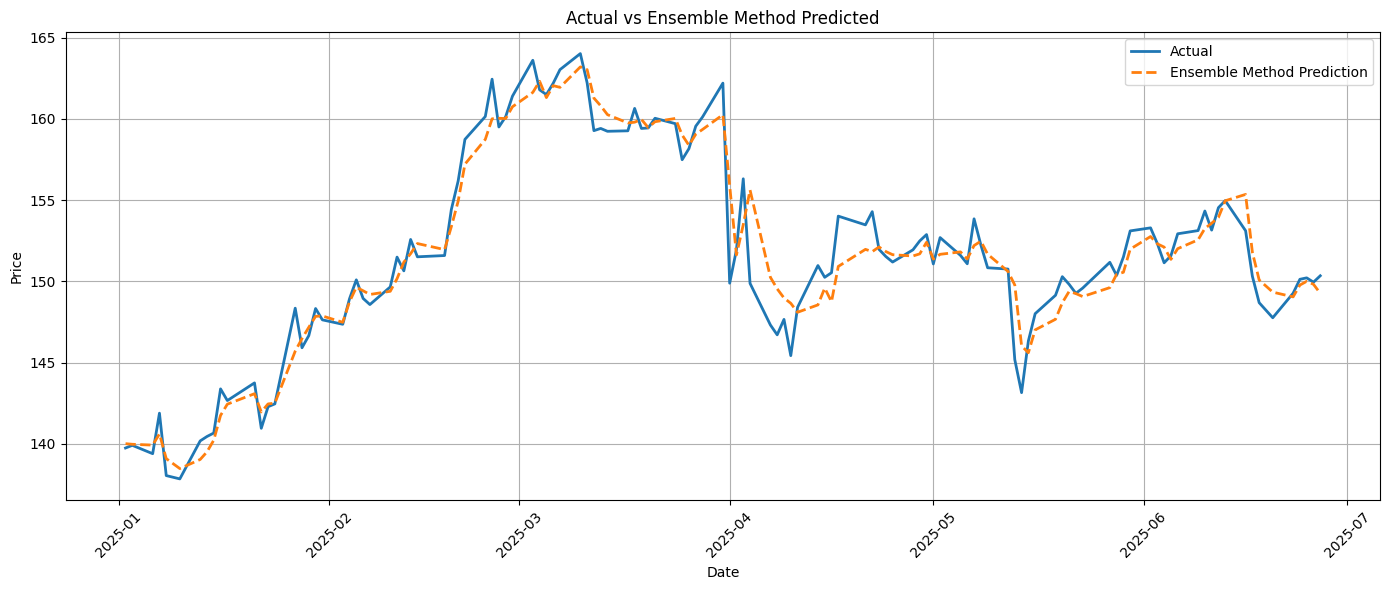

In [129]:
plt.figure(figsize=(14, 6))
plt.plot(summary_df['Date'], summary_df['Actual'], label='Actual', linewidth=2)
plt.plot(summary_df['Date'], summary_df['Ensemble Method Prediction'], label='Ensemble Method Prediction', linewidth=2, linestyle='--')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Ensemble Method Predicted')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()